In [1]:
import os
import pickle as pkl
import sys
import matplotlib.gridspec as gridspec
from scipy import optimize
import matplotlib.pyplot as plt
try:
    os.environ['SESNPATH']
    os.environ['SESNCFAlib']

except KeyError:
    print ("must set environmental variable SESNPATH and SESNCfAlib")
    sys.exit()

cmd_folder = os.getenv("SESNCFAlib")
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)
cmd_folder = os.getenv("SESNCFAlib") + "/templates"
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from savgol import savitzky_golay
from snclasses import *
import templutils as templutils
# from makePhottable import *
# from colors import rgb_to_hex
# from ubertemplates import *
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, MaxNLocator

from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.mlab as mlab
from select_lc import *
from Functions import *
import pandas as pd
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
SNTYPES = ['Ib','IIb','Ic','Ic-bl', 'Ibn']

bands = ['R','V','r','g','U','u','J','B','H','I','i','K','m2','w1','w2']
colorTypes = {'IIb':'FireBrick',
             'Ib':'SteelBlue',
             'Ic':'DarkGreen',
             'Ic-bl':'DarkOrange',
             'Ibn':'purple'}
colors = ['SteelBlue', 'g',  'red','purple']

In [3]:
lsst_bands = {'0':'u',
              '1':'g',
              '2': 'r',
              '3': 'i',
              '4': 'z',
              '5': 'y'}

clrs =  {'0':'b',
              '1':'g',
              '2': 'r',
              '3': 'purple',
              '4': 'cyan',
              '5': 'k'}
su = templutils.setupvars()
coffset = su.coffset

ref = coffset['r']
for b in coffset.keys():
    coffset[b] = coffset[b] - ref

In [4]:
# Reading in the GP templates

tmpl = {}

for bb in bands:

    tmpl[bb] = {}

    for SNTYPE in SNTYPES:
        
        tmpl[bb][SNTYPE] = {}



        try:
            path = "./../outputs/GPs_2022/GPalltemplfit_%s_%s_V0.pkl"%(SNTYPE,bb)
            tmpl_ = pkl.load(open(path, "rb"))
        except:
            continue
        

        if np.nansum(tmpl_['rollingMedian']) == 0:
            print(bb, SNTYPE)
            continue

        tmpl[bb][SNTYPE] = tmpl_

In [5]:
# Read in Plasticc train set
df1 = pd.read_csv('plasticc_train_lightcurves.csv') #plasticc_train_lightcurves.csv #./../../../../../../../../Downloads/plasticc_test_set_batch1.csv
df2 = pd.read_csv('plasticc_train_metadata.csv') #plasticc_train_metadata.csv # ./../../../../../../../../Downloads/plasticc_test_metadata.csv

In [6]:
len(df2.object_id[(df2.true_target == 62)].values)

484

In [7]:
# Select SESNe (code 62) and redshifts<0.2

SN_Ibc_id = df2.object_id[(df2.true_target == 62) & (df2.true_z <= 0.2)].values
df1 = df1[df1['object_id'].isin(SN_Ibc_id)]
df1 = df1.reset_index(drop = True)

In [8]:
df2 = df2[(df2.true_target == 62) & (df2.true_z <= 0.2)]

In [9]:
df1.columns

Index(['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected_bool'], dtype='object')

In [10]:
# Select light curves where the minimum SNR is 10 in r band
bn = 2
high_SN = df1.object_id[df1.passband == bn]\
                       [df1.flux[df1.passband == bn]/df1.flux_err[df1.passband == bn] > 10].unique()
len(high_SN)

205

Total number of good lc is  58


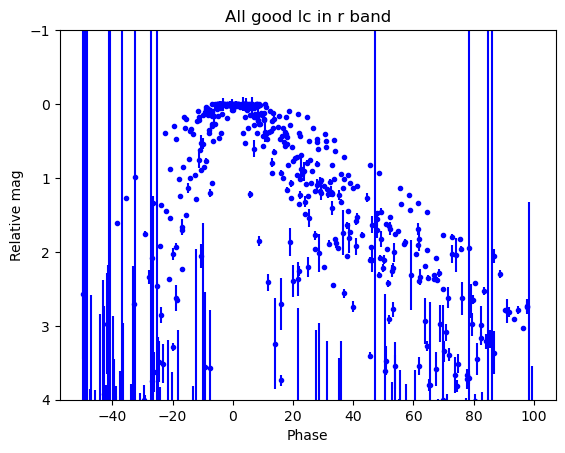

In [11]:
# Here we check how the total number of selected lc change when time_around_peak_limit changes

ID_selected = []
bn = 2
tot = len(high_SN)
time_around_peak_limit = 10

for i, ID in enumerate(high_SN):

    df_tmp = df1[(df1.passband == bn)&(df1.object_id == ID)]
    
    df_tmp = df_tmp[df_tmp.flux>0]
    
    t = df_tmp.mjd.values
    f = df_tmp.flux.values
    ferr = df_tmp.flux_err.values
    
    t_peak = df2.true_peakmjd[df2.object_id == ID].values
    
    if len(t[(t > t_peak - time_around_peak_limit) & (t < t_peak + time_around_peak_limit)]) < 2:
        tot -= 1
        continue
        
        
    
    
    low_lim = -50
    up_lim = 100
    
    ind = (t < up_lim + t_peak) & (t > low_lim + t_peak)
    
    y = f[ind]
    yerr = ferr[ind]
    x = t[ind]
    
    m = 27.5 - 2.5*np.log10(y)
    merr = 2.5 / np.log(10) * yerr / y


    tt = np.linspace(x.min(), x.max(), 1000)
    
    if len(y)<4:
        tot -= 1
        continue

        
    interpld = interp1d(x, y, kind='nearest')(tt)
#     t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak = x_peak)
    m_func = 27.5 - 2.5*np.log10(interpld)
    
    ind_ymin = (tt - t_peak < time_around_peak_limit) & (tt - t_peak > -time_around_peak_limit)
    
    if len(m_func[ind_ymin]) == 0:
        tot -= 1
        continue
    ID_selected.append(ID)
    
    ymin = np.min(m_func[ind_ymin])
    
    plt.errorbar(x - t_peak, m - ymin, yerr=merr, fmt = '.', color = 'b')
#     plt.plot(tt - t_peak, m_func - ymin, 'k')
#     plt.xlim(-20, 100)
    
    

plt.title('All good lc in r band')
plt.xlabel('Phase')
plt.ylabel('Relative mag')

plt.ylim(-1, 4)
plt.gca().invert_yaxis()

print('Total number of good lc is ', tot)
    

/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:176: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if x_peak == 'None':
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:88: RuntimeWarning: overflow encountered in square
  return (np.sum((f-model)**2*inv_sigma2))
/Users/somayeh/Library/Mobile Documents/com~apple~CloudDocs/Research/SNe_templates/GPSNtempl/maketemplates/Plasticc_I/Functions.py:70: RuntimeWarning: overflow encountered in power
  exp_rise = np.e**(np.asarray(shift * (t - t0))) + 1


(-25.0, 20.0)

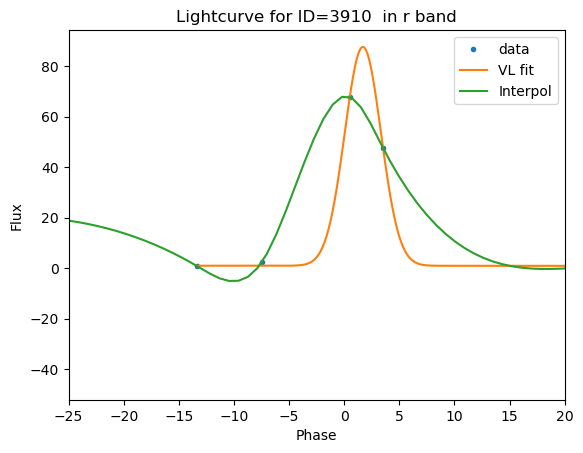

In [12]:
# plot a single Plasticc light curve - Compare cubic interpolation with VL fit
ID = 3910
bn = 2 # for band r
df_tmp = df1[(df1.passband == bn)&(df1.object_id == ID)]
df_tmp = df_tmp[df_tmp.flux>0]
t = df_tmp.mjd.values
f = df_tmp.flux.values
ferr = df_tmp.flux_err.values

tt = np.linspace(t.min(), t.max(), 1000)

t_peak = df2.true_peakmjd[df2.object_id == ID].values

t_new, func, p0 = lc_fit(np.row_stack((t, f, ferr)), x_peak= t_peak)
interpld = interp1d(t, f, kind='cubic')(tt)

plt.plot(t-t_peak,f, '.', label = 'data')
plt.plot(t_new,func, '-', label = 'VL fit')
plt.plot(tt-t_peak,interpld, '-', label = 'Interpol')

plt.title('Lightcurve for ID=' + str(ID) +'  in r band')
plt.xlabel('Phase')
plt.ylabel('Flux')

plt.legend()


plt.xlim(-25, 20)

In [13]:
len(ID_selected)

58

/var/folders/6f/k2kn3hn52ws4kc_w0_zqfpy40000gp/T/ipykernel_70586/3507320473.py:70: RuntimeWarning: invalid value encountered in log10
  m_func = 27.5 - 2.5*np.log10(interpld)


Text(0.04, 0.5, 'Relative Magnitude')

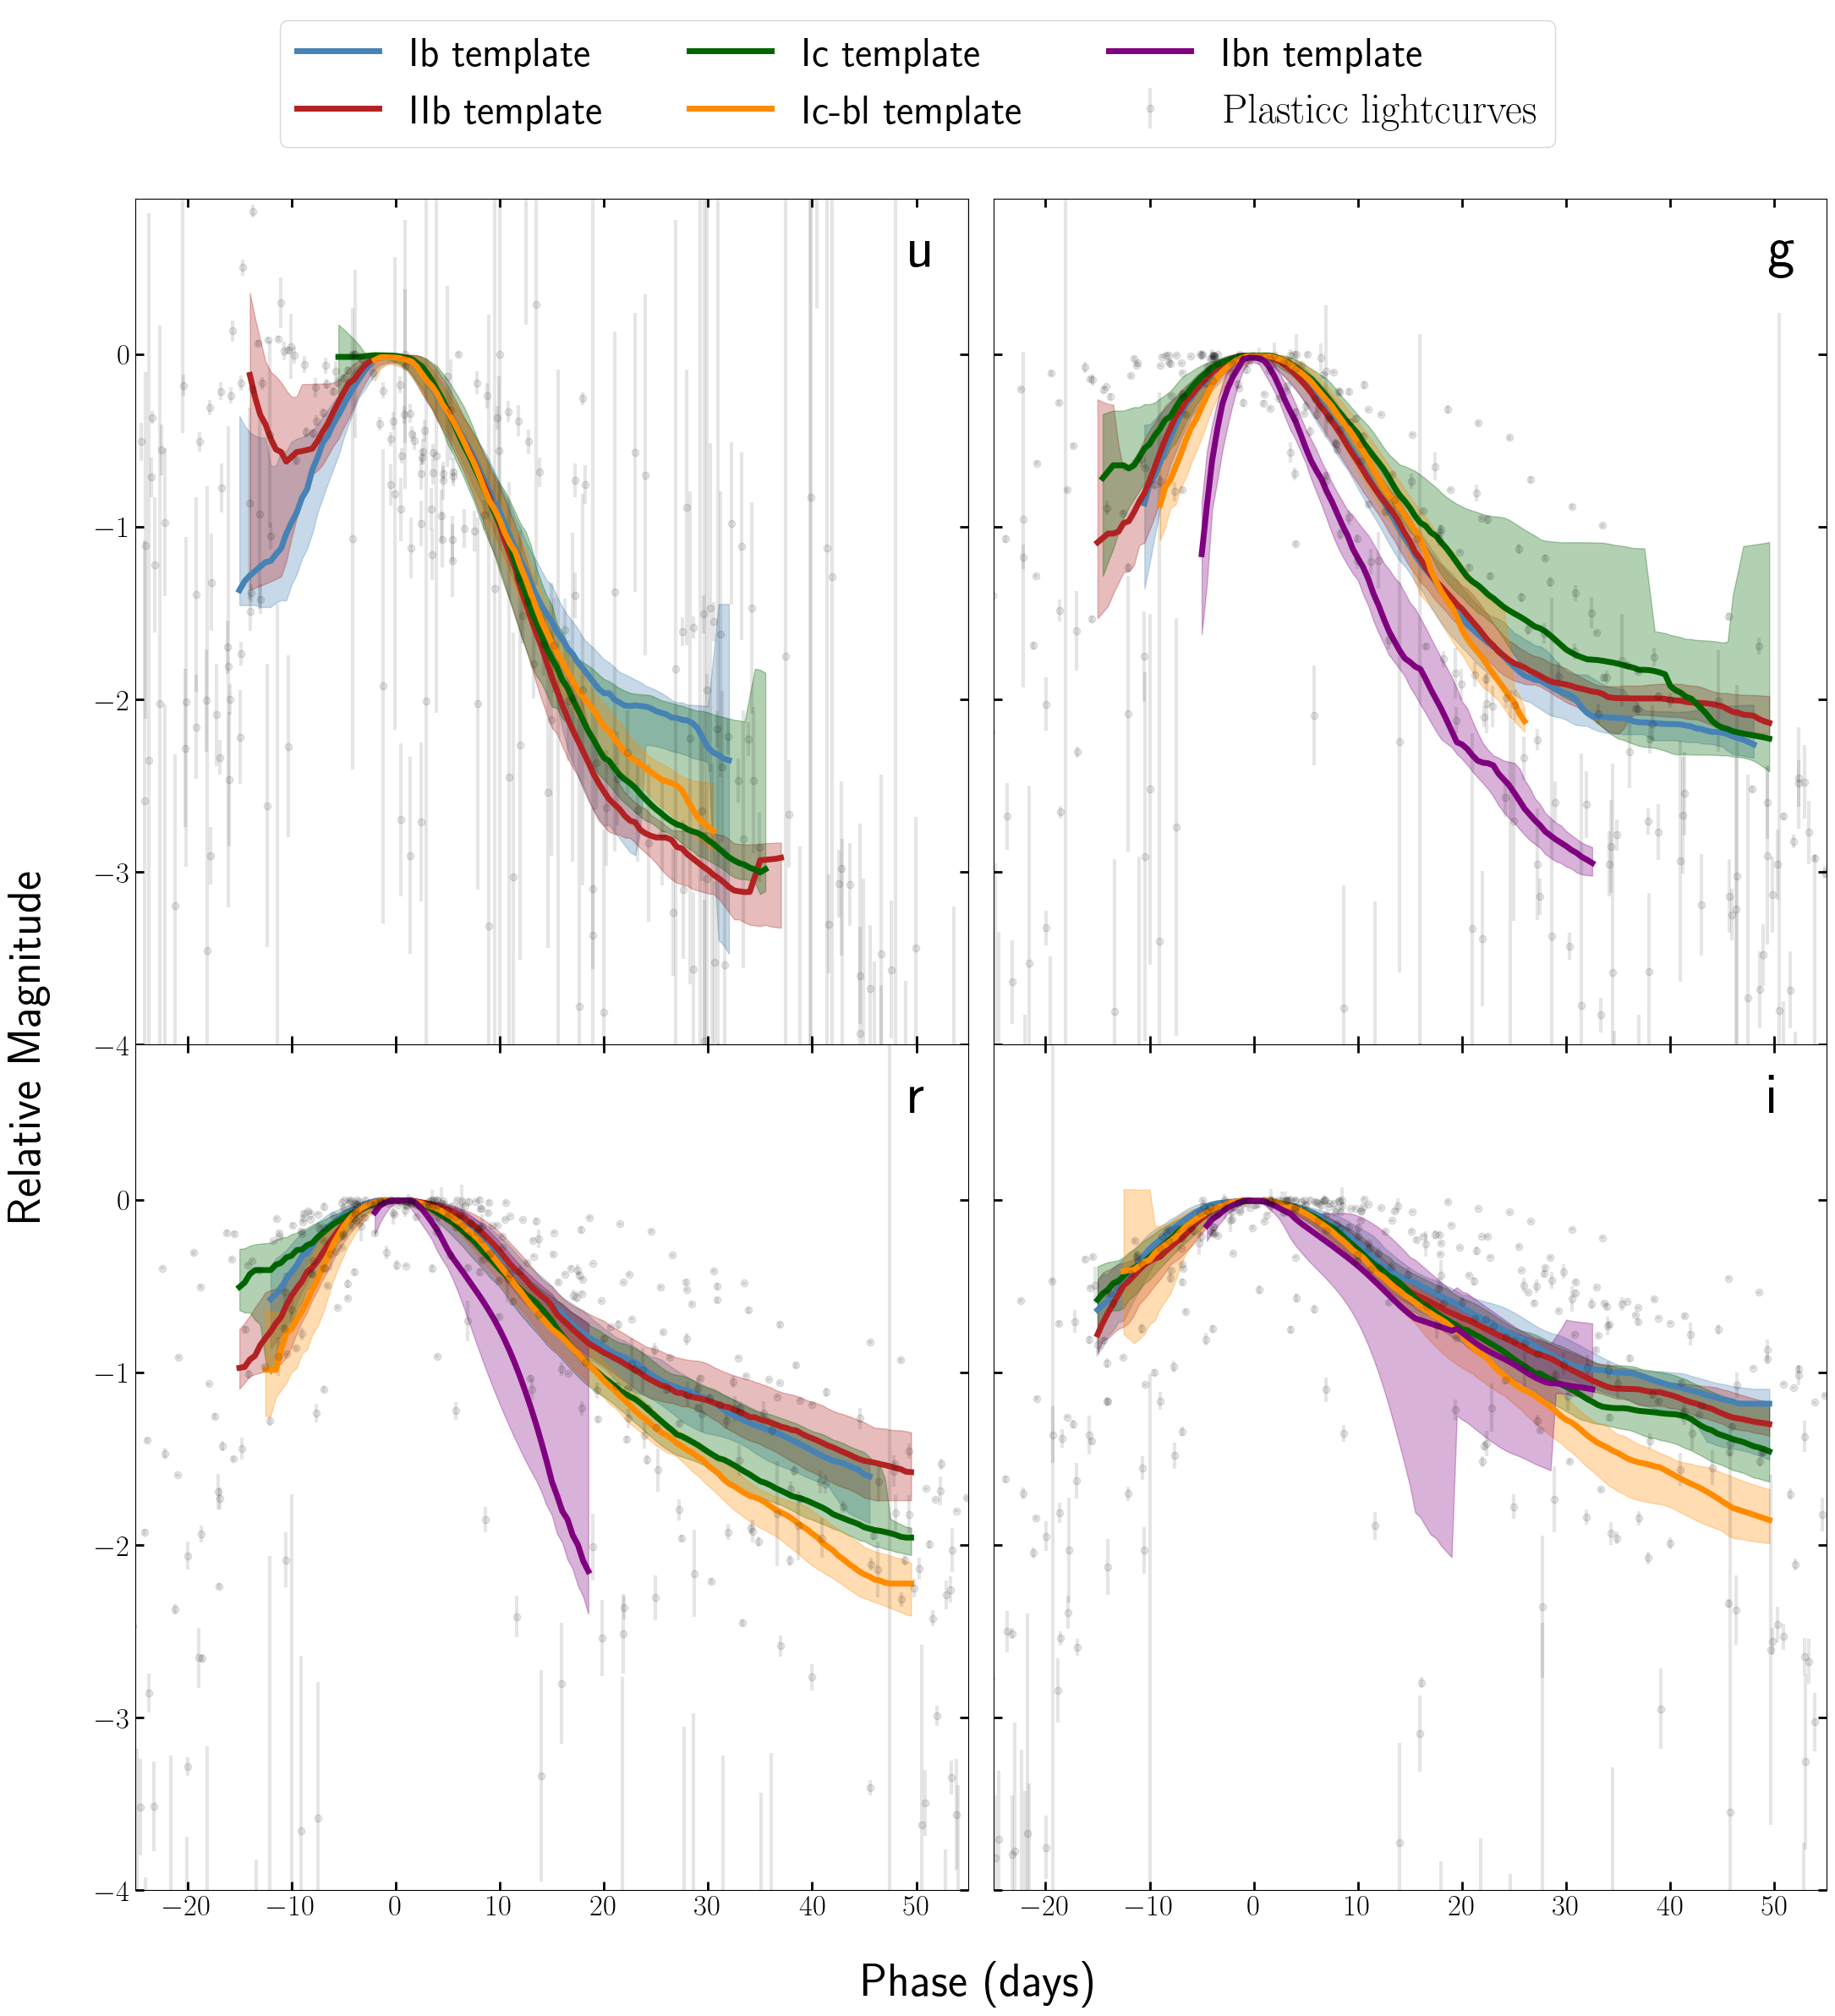

In [20]:
# ugrizy = 012345
bb = ['u','g','r','i']
b_ = [0,1,2,3]

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']



# u, g, r, i

max_u = [[],[]]
max_g = [[],[]]
max_r = [[],[]]
max_i = [[],[]]


plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.preamble']=r'\makeatletter \newcommand*{\rom}[1]{\expandafter\@slowromancap\romannumeral #1@} \makeatother'

# print(band_sntypes)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(25,25))

diff_u, diff_g, diff_r, diff_i = [], [], [], []

plasticc_selected = {}

for b in b_: 
    plasticc_selected[bb[b]] = {}
    band_sntypes = [*tmpl[bb[b]]]
    
    for i, ID in enumerate(ID_selected):
        

        df_new = df1[(df1.object_id == ID) & (df1.passband == b)]
        
        df_new = df_new[df_new.flux>0]
        
        t = df_new.mjd.values
        f = df_new.flux.values
        ferr = df_new.flux_err.values

        t_peak = df2.true_peakmjd[df2.object_id == ID].values

        low_lim = -50
        up_lim = 100

        ind = (t < up_lim + t_peak) & (t > low_lim + t_peak)

        y = f[ind]
        yerr = ferr[ind]
        x = t[ind]

        m = 27.5 - 2.5*np.log10(y)
        merr = 2.5 / np.log(10) * yerr / y
        

        

        if len(y)<4:
#             print(ID, bb[b])
            continue
            
        tt = np.linspace(x.min(), x.max(), 1000)
        


        interpld = interp1d(x, y, kind='cubic')(tt)
    #     t_new, func, p0 = lc_fit(np.row_stack((x, f[ind], ferr[ind])), x_peak = x_peak)
        m_func = 27.5 - 2.5*np.log10(interpld)

        ind_ymin = (tt - t_peak < time_around_peak_limit) & (tt - t_peak > -time_around_peak_limit)

        if len(m_func[ind_ymin]) == 0:
            tot -= 1
            continue

        ymin = np.nanmin(m_func[ind_ymin])
        
        plasticc_selected[bb[b]][ID] = {}
        plasticc_selected[bb[b]][ID]['phs'] = x - t_peak
        plasticc_selected[bb[b]][ID]['mag'] = ymin - m
        plasticc_selected[bb[b]][ID]['err'] = merr
        
               
        
        if i == 0:

            np.concatenate(ax)[b].errorbar(x - t_peak, ymin - m, yerr=merr, fmt='o',\
                linewidth = 3, color = 'k', alpha=0.1, label = r'$\mathrm{Plasticc } \; \mathrm{ light curves}$')
#             np.concatenate(ax)[b].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'r', alpha = 0.5, label = 'VL fit')
                                       
                    
        else:
            np.concatenate(ax)[b].errorbar(x - t_peak, ymin - m, yerr=merr, fmt='o',\
                linewidth = 3, color = 'k', alpha=0.1
                                          )
#             np.concatenate(ax)[b].plot(t_new - new_t_peak,\
#                 new_y_peak - m_func,\
#                 '-', linewidth = 0.1, color = 'r', alpha = 0.5)


    for tp in band_sntypes:
        if b == 2:
            try:
                if tp == 'Ib':
                    up_lim = 55
                else:
                    up_lim = 55

                np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingMedian'][tmpl[bb[b]][tp]['t']<up_lim],\
                        '-',color = colorTypes[tp],linewidth=5, label = tp + ' template')
                np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingPc25'][tmpl[bb[b]][tp]['t']<up_lim],\
                        tmpl[bb[b]][tp]['rollingPc75'][tmpl[bb[b]][tp]['t']<up_lim],\
                        alpha = 0.3, color = colorTypes[tp])
            except:
                pass 
        else:
            
            
            try:
                if b == 1 and tp == 'Ic':

                    np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingMedian'][tmpl[bb[b]][tp]['t']<55],\
                            '-',color = colorTypes[tp],linewidth=5)
                    np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingPc25'][tmpl[bb[b]][tp]['t']<55],\
                            tmpl[bb[b]][tp]['rollingPc75'][tmpl[bb[b]][tp]['t']<55],\
                            alpha = 0.3, color = colorTypes[tp])
                
                else:
                    np.concatenate(ax)[b].plot(tmpl[bb[b]][tp]['t'],\
                            tmpl[bb[b]][tp]['rollingMedian'],\
                            '-',color = colorTypes[tp],linewidth=5)
                    np.concatenate(ax)[b].fill_between(tmpl[bb[b]][tp]['t'],\
                            tmpl[bb[b]][tp]['rollingPc25'],\
                            tmpl[bb[b]][tp]['rollingPc75'],\
                            alpha = 0.3, color = colorTypes[tp])
            except:
                    pass 

    #     plt.title('Plasticc I light curves compared with GP templates in ' + str(bb) + ' band', size=30)
        
#         plt.legend(loc = 'lower left', ncol=3, prop={'size':30})
        np.concatenate(ax)[b].tick_params(axis="both", direction="in", which="major",\
                                              right=True, top=True, size=7, labelsize=25, width = 2)
    
    np.concatenate(ax)[b].text(0.93, 0.92, bb[b], transform=np.concatenate(ax)[b].transAxes,\
                               weight='bold', size = 50, color = 'k')
    
handles, labels = np.concatenate(ax)[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, prop={'size':35})
# np.concatenate(ax)[0].set_yticklabels(['','-7', '-6','-5', '-4', '-3','-2', '-1', '0'], size=30)
# np.concatenate(ax)[2].set_yticklabels(['','-7', '-6', '-5', '-4', '-3','-2', '-1', '0'], size=30)

# np.concatenate(ax)[2].set_xticklabels(['', '-20', '-10','0', '10', '20','30', '40', '50', ''], size=30)
# np.concatenate(ax)[3].set_xticklabels(['', '-20','-10','0', '10', '20', '30', '40', '50', ''], size=30)


np.concatenate(ax)[0].set_xlim(-25,55)
np.concatenate(ax)[0].set_ylim(-4,0.9)
plt.subplots_adjust(hspace=.0, wspace=0.03, top = 0.9, left = 0.1, bottom = 0.1)

fig.text(0.5, 0.05, 'Phase (days)', ha='center', size = 40)
fig.text(0.04, 0.5, 'Relative Magnitude', va='center', rotation='vertical', size = 40)


# plt.savefig('plasticc_gp_tmpl_ugri_high_SN_peak_covered6.pdf', bbox_inches='tight')

In [21]:
file = open('./../share_tmpls/plasticc.pkl', 'wb')
pickle.dump(plasticc_selected, file)

In [99]:
m[0, :,:] = np.asarray([[3,3,3],[32,1,2], [4,3,3]]).reshape((3,3,1))

m[0

In [100]:
m[0]

array([[[ 3.],
        [ 3.],
        [ 3.]],

       [[32.],
        [ 1.],
        [ 2.]],

       [[ 4.],
        [ 3.],
        [ 3.]]])